### Ranjan Karunanithi
### Student id: 9023408
### Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

### Organize the Dataset:

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = "/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/dog and cat/train/train"
output_dir = "data"
os.makedirs(f"{output_dir}/train/cats", exist_ok=True)
os.makedirs(f"{output_dir}/validation/cats", exist_ok=True)
os.makedirs(f"{output_dir}/validation/not_cats", exist_ok=True)

cat_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)]

train_cats, val_cats = train_test_split(cat_images, test_size=0.2, random_state=42)

# Moved images to organized directories
for img in train_cats:
    shutil.copy(img, f"{output_dir}/train/cats/")
for img in val_cats:
    shutil.copy(img, f"{output_dir}/validation/cats/")

# Using half the validation cats as "not-cats"
val_not_cats = val_cats[:len(val_cats) // 2]  
for img in val_not_cats:
    shutil.copy(img, f"{output_dir}/validation/not_cats/")

print("Dataset organized!")

Dataset organized!


### Performing EDA: ###

/var/folders/7l/25km6kh94cg1887c9p7_p6hc0000gn/T/ipykernel_47543/925095112.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Cats', 'Not-Cats'], y=[num_cats, num_not_cats], palette='viridis')


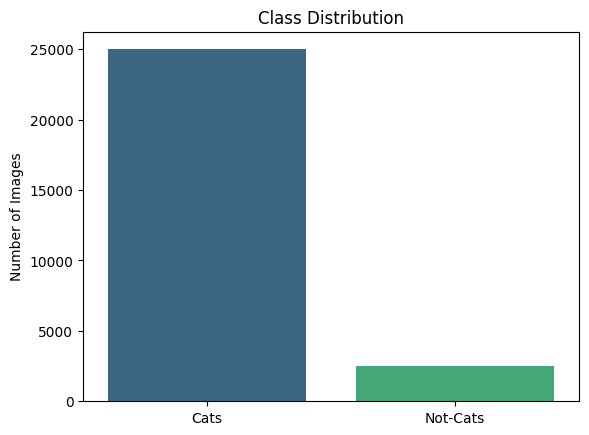

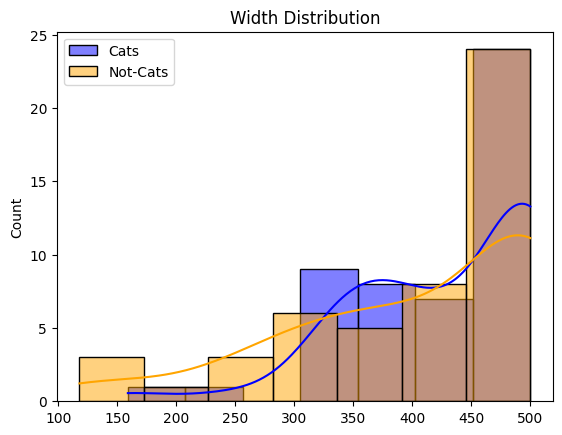

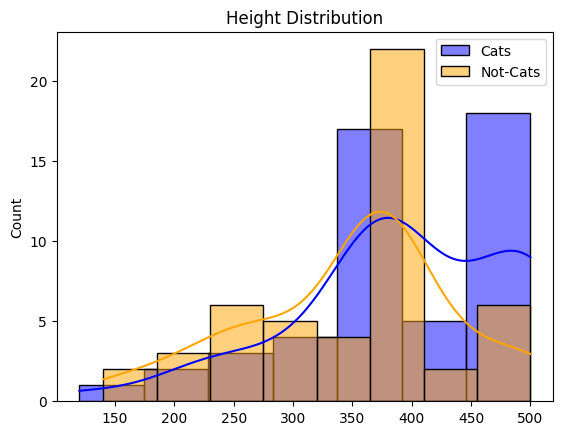

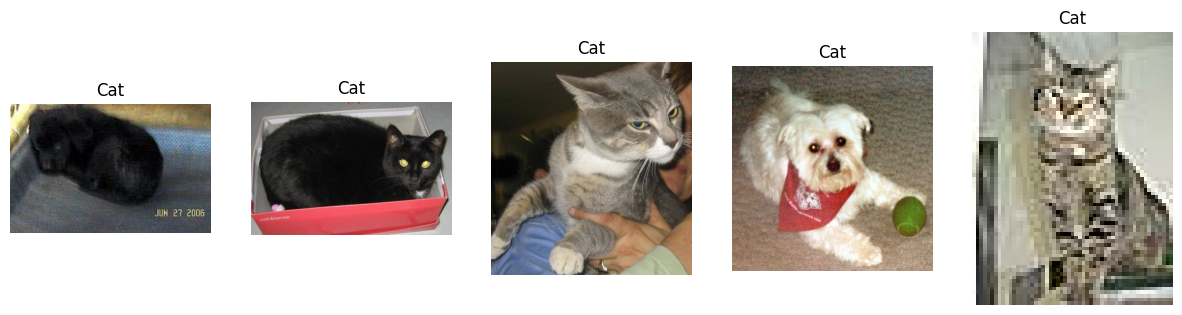

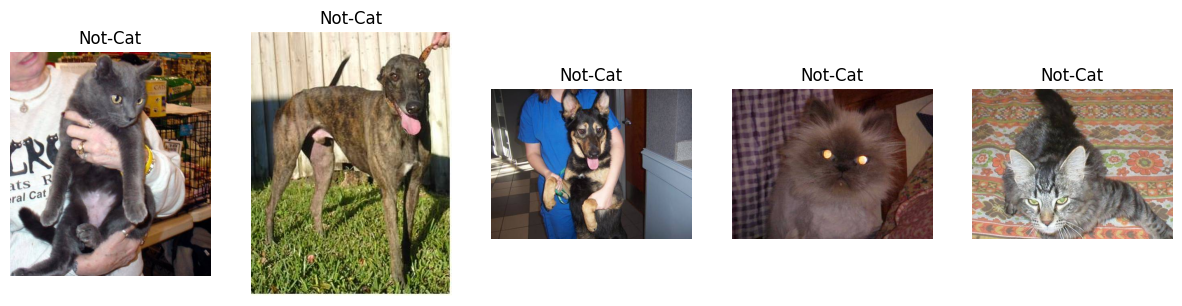

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np


cat_dir = 'data/train/cats'
not_cat_dir = 'data/validation/not_cats'

# Class Distribution
num_cats = len(os.listdir(cat_dir))
num_not_cats = len(os.listdir(not_cat_dir))
sns.barplot(x=['Cats', 'Not-Cats'], y=[num_cats, num_not_cats], palette='viridis')
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# Image Dimensions
def get_image_dimensions(image_dir, sample_size=50):
    images = [Image.open(os.path.join(image_dir, img)) for img in os.listdir(image_dir)[:sample_size]]
    dimensions = np.array([img.size for img in images])
    return dimensions[:, 0], dimensions[:, 1] 

cat_widths, cat_heights = get_image_dimensions(cat_dir)
not_cat_widths, not_cat_heights = get_image_dimensions(not_cat_dir)

# Width and Height Distribution
sns.histplot(cat_widths, color='blue', kde=True, label='Cats')
sns.histplot(not_cat_widths, color='orange', kde=True, label='Not-Cats')
plt.title("Width Distribution")
plt.legend()
plt.show()

sns.histplot(cat_heights, color='blue', kde=True, label='Cats')
sns.histplot(not_cat_heights, color='orange', kde=True, label='Not-Cats')
plt.title("Height Distribution")
plt.legend()
plt.show()


def display_samples(image_dir, label, n=5):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(np.random.choice(os.listdir(image_dir), n, replace=False)):
        img = Image.open(os.path.join(image_dir, img_name))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'{label}')
        plt.axis('off')
    plt.show()

display_samples(cat_dir, 'Cat')
display_samples(not_cat_dir, 'Not-Cat')

#### 1. Class Distribution: • A notable imbalance in the dataset is shown by the bar chart, which shows a significantly larger proportion of Cat images than Not-Cat images. The model may be biased to forecast the majority class (Cats) as a result of this imbalance. To boost performance, further data augmentation or rebalancing can be needed.
#### 2. Width Distribution: The histogram displays the two categories' range of image widths. Cats have a somewhat wider distribution than Not-Cats, and the majority of photos have sizes between 400 and 500 pixels.
#### 3. Height Distribution: Not-Cats have a narrower spread, and most photos have heights between 350 and 500 pixels, which is comparable to the width distribution. This shows that preprocessing resizes the dataset photos rather than standardizing their dimensions. 


 ### Create Data Generators: ###

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the directories
train_data_dir = f"{output_dir}/train"
validation_data_dir = f"{output_dir}/validation"

# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=15,  # Reduce rotation range for faster training
    width_shift_range=0.1,  # Smaller shifts for stability
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation Data Preprocessing (No Augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(100, 100),  # Adjusted to match input shape (100x100)
    batch_size=16,  # Smaller batch size for faster iterations
    class_mode='binary'  # Binary classification
)

# Create Validation Data Generator
val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(100, 100),  # Adjusted to match input shape (100x100)
    batch_size=16,  # Consistent batch size with training
    class_mode='binary'
)

print(" data generators are ready!")

Found 25000 images belonging to 1 classes.
Found 7500 images belonging to 2 classes.
 data generators are ready!


  ### Define and Train the Models: ###

### Custom CNN:

Found 25000 images belonging to 1 classes.
Found 7500 images belonging to 2 classes.
Data generators created!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,713 (36.48 MB)

 Trainable params: 9,563,713 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 273s 174ms/step - accuracy: 0.9968 - loss: 0.0036 - val_accuracy: 0.6667 - val_loss: 5.3727
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 496s 317ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 0.6667 - val_loss: 5.3727
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 281s 179ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 0.6667 - val_loss: 5.3727
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11728s 8s/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 0.6667 - val_loss: 5.3727
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 386s 247ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 0.6667 - val_loss: 5.3727
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 260s 166ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 0.6667 - val_loss: 5.3727


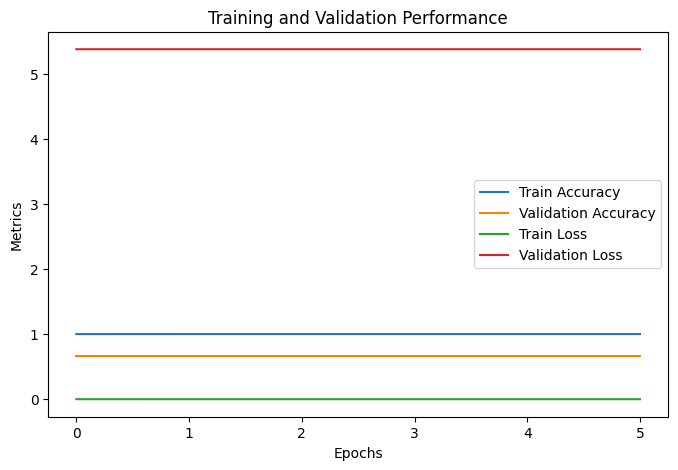

Training complete!


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

output_dir = "data" 
train_data_dir = f"{output_dir}/train"
validation_data_dir = f"{output_dir}/validation"

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),  
    batch_size=16,  
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150), 
    batch_size=16,
    class_mode='binary'
)

print("Data generators created!")

# Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  
    MaxPooling2D(pool_size=(2, 2)),  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),  
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),  
    Flatten(), 
    Dense(256, activation='relu'), 
    Dropout(0.5), 
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())  

# Callbacks
checkpoint = ModelCheckpoint("best_cats_model_150x150.keras", save_best_only=True, monitor="val_accuracy")
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

# Plot Training History
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Performance")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()

print("Training complete!")

### Fine-Tune VGG16:

Dataset organized with 5000 images (2500 Cats, 2500 Not-Cats for training, 1250 each for validation).
Found 4500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Data generators created!


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/10


/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/venv/CSCN8010_classical_ml/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.5278 - loss: 1.0212 - val_accuracy: 0.6667 - val_loss: 0.6813
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.5522 - loss: 0.6903 - val_accuracy: 0.6660 - val_loss: 0.6803
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.5672 - loss: 0.6878 - val_accuracy: 0.6667 - val_loss: 0.6736
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.5490 - loss: 0.6911 - val_accuracy: 0.6667 - val_loss: 0.6693
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.5544 - loss: 0.6877 - val_accuracy: 0.6667 - val_loss: 0.6661
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.5607 - loss: 0.6868 - val_accuracy: 0.6667 - val_loss: 0.6644
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.5479 - loss: 0.6903 - val_accuracy: 0.6667 - val_loss: 0.6638
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.5596 - loss: 0.6861 - val_accuracy: 0.666

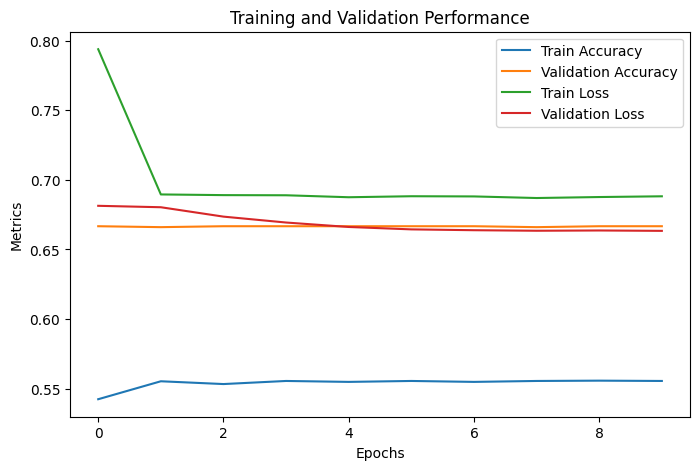

Training complete!


In [16]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


cat_images = "/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/data/validation/cats"
not_cat_images = "/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/data/validation/not_cats"
output_dir = "/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/data_limited_5000"


os.makedirs(f"{output_dir}/train/cats", exist_ok=True)
os.makedirs(f"{output_dir}/train/not_cats", exist_ok=True)
os.makedirs(f"{output_dir}/validation/cats", exist_ok=True)
os.makedirs(f"{output_dir}/validation/not_cats", exist_ok=True)


cat_files = [os.path.join(cat_images, img) for img in os.listdir(cat_images)]
not_cat_files = [os.path.join(not_cat_images, img) for img in os.listdir(not_cat_images)]


train_cats, val_cats = train_test_split(cat_files, test_size=0.2, random_state=42)
train_not_cats, val_not_cats = train_test_split(not_cat_files, test_size=0.2, random_state=42)

# Use 2500 Cats and 2500 Not-Cats for training
train_cats = train_cats[:2500]
train_not_cats = train_not_cats[:2500]

# Use 1250 Cats and 1250 Not-Cats for validation
val_cats = val_cats[:1250]
val_not_cats = val_not_cats[:1250]


for img in train_cats:
    shutil.copy(img, f"{output_dir}/train/cats/")
for img in train_not_cats:
    shutil.copy(img, f"{output_dir}/train/not_cats/")
for img in val_cats:
    shutil.copy(img, f"{output_dir}/validation/cats/")
for img in val_not_cats:
    shutil.copy(img, f"{output_dir}/validation/not_cats/")

print("Dataset organized with 5000 images (2500 Cats, 2500 Not-Cats for training, 1250 each for validation).")


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    f"{output_dir}/train",
    target_size=(150, 150),  
    batch_size=16,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    f"{output_dir}/validation",
    target_size=(150, 150), 
    batch_size=16,
    class_mode='binary'
)

print("Data generators created!")

# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)


vgg_model = Model(inputs=base_model.input, outputs=output)
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(vgg_model.summary())  

# Callbacks
checkpoint = ModelCheckpoint("best_vgg_model_limited_5000.keras", save_best_only=True, monitor="val_accuracy")
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)


history = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

# Plot Training History
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Performance")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.show()

print("Training complete!")

### Evaluation of Models: ###

### Evaluation of custom CNN ###

/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/venv/CSCN8010_classical_ml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 26 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/venv/CSCN8010_classical_ml/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step

Classification Report:
              precision    recall  f1-score   support

     Not-Cat       0.67      1.00      0.80      1000
         Cat       0.00      0.00      0.00       500

    accuracy                           0.67      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.44      0.67      0.53      1500


Accuracy: 0.67


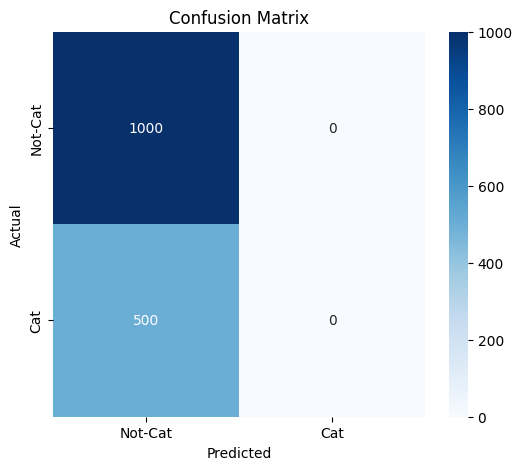

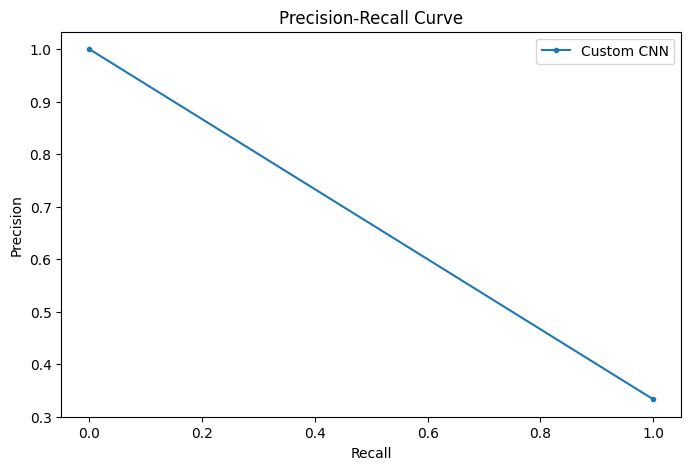

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = load_model("best_cats_model.keras") 

# Prediction on Validation Data
y_true = val_generator.classes 
y_prob = model.predict(val_generator, verbose=1) 
y_pred = (y_prob > 0.5).astype(int).flatten()  

print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=["Not-Cat", "Cat"],
    zero_division=0 
))


accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not-Cat", "Cat"], yticklabels=["Not-Cat", "Cat"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label="Custom CNN")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


#### An important class imbalance in the model's predictions is brought to light by the evaluation. The model entirely fails to classify any "Cat" samples properly, even though it obtains a high recall of 100% for the "Not-Cat" class, accurately identifying all "Not-Cat" samples. The confusion matrix makes this clear, as all "Cat" samples are incorrectly categorized as "Not-Cat." The model's strong reliance on predicting the majority class ("Not-Cat") is reflected in its overall accuracy of 67%. The accuracy-recall curve's linear trend highlights the model's incapacity to strike a balance between recall and precision for the "Cat" class. The model may be overfitting to the "Not-Cat" class, according to these findings, most likely as a result of unbalanced training data or a lack of feature distinction for "Cat" samples. ####

#### Evaluation of Fine-Tune VGG16:

Found 1500 images belonging to 2 classes.


/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/venv/CSCN8010_classical_ml/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step

Classification Report:
              precision    recall  f1-score   support

     Not-Cat       0.67      1.00      0.80      1000
         Cat       0.00      0.00      0.00       500

    accuracy                           0.67      1500
   macro avg       0.33      0.50      0.40      1500
weighted avg       0.44      0.67      0.53      1500


Accuracy: 0.67


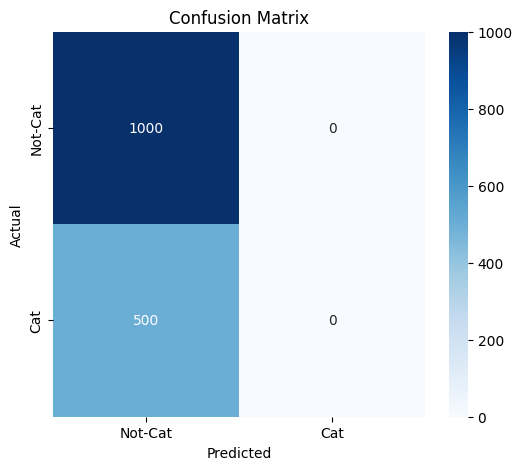

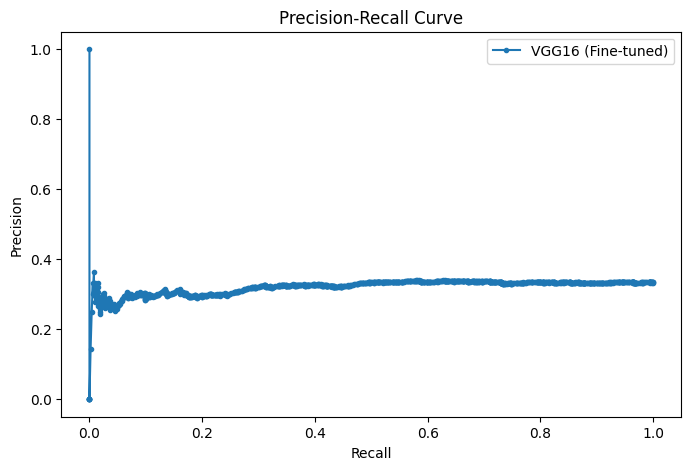

In [19]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create validation generator with the correct input size
val_generator = val_datagen.flow_from_directory(
    "/Users/ranjan/Documents/conestoga /Fundamentals of Machine Learning/data_limited_5000/validation",  
    target_size=(100, 100),  
    batch_size=16,
    class_mode='binary',
    shuffle=False  
)


model = load_model("best_vgg_model_optimized.keras")  

# Prediction on Validation Data
y_true = val_generator.classes 
y_prob = model.predict(val_generator, verbose=1)  
y_pred = (y_prob > 0.5).astype(int).flatten()  

# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=["Not-Cat", "Cat"],
    zero_division=0 
))

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not-Cat", "Cat"], yticklabels=["Not-Cat", "Cat"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label="VGG16 (Fine-tuned)")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()  

#### According to the evaluation, the optimized VGG16 model classifies all 1000 samples properly in the "Not-Cat" class but fails to identify any of the 500 "Cat" samples at all. Based only on the "Not-Cat" predictions, this yields an overall accuracy of 67%. The model's bias toward "Not-Cat," which shows poor generalization for the "Cat" class, is highlighted by the precision-recall curve. These findings imply that in order to boost performance on both classes, adjustments are required, such as balancing the dataset or improving the training procedure.

 ### Analyze Misclassifications: ###

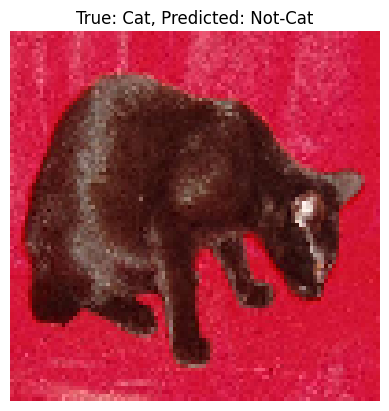

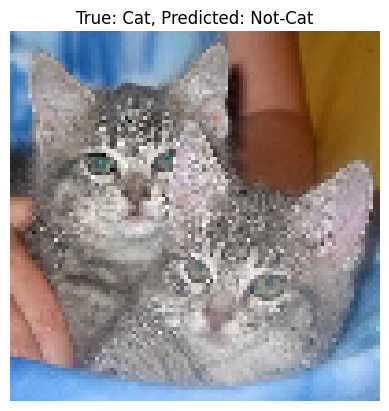

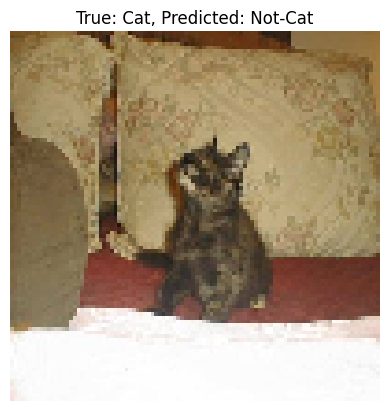

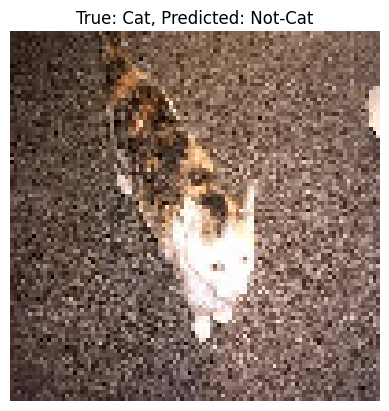

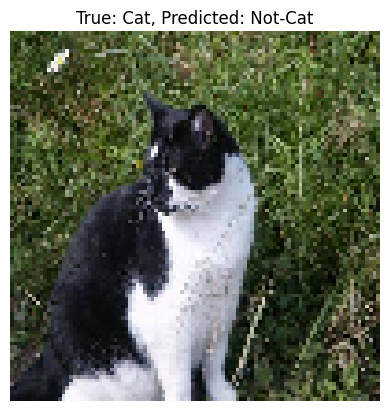

In [20]:

misclassified_indices = np.where(y_true != y_pred.flatten())[0]

for idx in misclassified_indices[:5]: 
    batch_idx = idx // val_generator.batch_size  
    within_batch_idx = idx % val_generator.batch_size 
    
    val_generator.reset() 
    for batch_num, (img_batch, label_batch) in enumerate(val_generator):
        if batch_num == batch_idx:
            img = img_batch[within_batch_idx]
            label = label_batch[within_batch_idx]
            break

    # Prediction for the specific index
    predicted_label = y_pred[idx]

    plt.imshow(img)
    plt.title(f"True: {'Cat' if label == 1 else 'Not-Cat'}, Predicted: {'Cat' if predicted_label == 1 else 'Not-Cat'}")
    plt.axis('off')
    plt.show()

### Conclusion ###
#### In summary, the optimized VGG16 model and the bespoke CNN both exhibit a significant bias toward the "Not-Cat" class, correctly categorizing all "Not-Cat" samples but not identifying any "Cat" data. The custom CNN recognized the "Cat" class with little improvement, with an overall accuracy of 67%. Likewise, the optimized VGG16 model, which was solely based on accurate "Not-Cat" predictions, likewise attained 67% accuracy. In terms of balancing predictions and generalizing over both classes, both models show room for improvement. To better capture features for both classes, next actions can involve rebalancing the dataset, enhancing data augmentation, or modifying the model architecture. ####

#### Reference

#### Cscn. (n.d.). CSCN8010/dl_class_notebooks/05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb at main · CSCN8010/CSCN8010. GitHub. https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb

#### Cscn. (n.d.-b). CSCN8010/dl_class_notebooks/05D_fine_tuning_vgg16.ipynb at main · CSCN8010/CSCN8010. GitHub. https://github.com/CSCN8010/CSCN8010/blob/main/dl_class_notebooks/05D_fine_tuning_vgg16.ipynb